# Variational EM

<p align="center">
  <img src="https://els-jbs-prod-cdn.jbs.elsevierhealth.com/cms/attachment/09c7213d-d3ef-4c84-8321-07ab84a365af/fx1.jpg" />
</p>

<!-- ![](https://els-jbs-prod-cdn.jbs.elsevierhealth.com/cms/attachment/09c7213d-d3ef-4c84-8321-07ab84a365af/fx1.jpg) -->

In this lab, we will implement a variational expectation-maximization (EM) algorithm to fit a latent variable model with both discrete and continuous states. We'll use a mean field approximation, which we'll fit using coordinate ascent variational inference (CAVI). Then we'll test it out on neural activity traces extracted from calcium imaging of the worm _C. elegans_ by Kato et al (2015), in their paper on low dimensional dynamics of whole brain activity.

We won't implement variational EM for full-blown switching linear dynamical systems, as described in clas. Instead, we'll work on a simpler model without time dependencies, which reduces to a mixture of factor analysis models. Once we've done so, you'll understand how the main fitting algorithms for SLDS work under the hood!


**References**

Kato, Saul, Harris S. Kaplan, Tina Schrödel, Susanne Skora, Theodore H. Lindsay, Eviatar Yemini, Shawn Lockery, and Manuel Zimmer. 2015. “Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis Elegans.” Cell 163 (3): 656–69.


## Setup

In [70]:
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import trange

# PyTorch
import torch
from torch.distributions import Categorical, MultivariateNormal, Normal, \
    LowRankMultivariateNormal, kl_divergence

device = torch.device('cpu')
dtype = torch.float32

# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

In [71]:
#@title Helper Functions (run this cell!)

import numpy as onp
from matplotlib.colors import LinearSegmentedColormap

kato_files = ["TS20140715e_lite-1_punc-31_NLS3_2eggs_56um_1mMTet_basal_1080s.mat",
              "TS20140715f_lite-1_punc-31_NLS3_3eggs_56um_1mMTet_basal_1080s.mat",
              "TS20140905c_lite-1_punc-31_NLS3_AVHJ_0eggs_1mMTet_basal_1080s.mat",
              "TS20140926d_lite-1_punc-31_NLS3_RIV_2eggs_1mMTet_basal_1080s.mat",
              "TS20141221b_THK178_lite-1_punc-31_NLS3_6eggs_1mMTet_basal_1080s.mat"]

kato_dir = '.'

# Set notebook plotting defaults
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["light blue",   # forward
                            "navy",         # slow
                            "orange",       # dorsal turn
                            "yellow",       # ventral turn
                            "red",          # reversal 1
                            "pink",         # reversal 2
                            "green",        # sustained reversal
                            "greyish"])     # no state

def load_kato_labels():
    zimmer_state_labels = \
        loadmat(os.path.join(
            kato_dir,
            "sevenStateColoring.mat"))
    return zimmer_state_labels

def load_kato_key():
    data = load_kato_labels()
    key = data["sevenStateColoring"]["key"][0,0][0]
    key = [str(k)[2:-2] for k in key]
    return key


def _get_neuron_names(neuron_ids_1, neuron_ids_2, worm_name):
    # Remove the neurons that are not uniquely identified
    def check_label(neuron_name):
        if neuron_name is None:
            return False
        if neuron_name == "---":
            return False

        neuron_index = onp.where(neuron_ids_1 == neuron_name)[0]
        if len(neuron_index) != 1:
            return False

        if neuron_ids_2[neuron_index[0]] is not None:
            return False

        # Make sure it doesn't show up in the second neuron list
        if len(onp.where(neuron_ids_2 == neuron_name)[0]) > 0:
            return False

        return True

    final_neuron_names = []
    for i, neuron_name in enumerate(neuron_ids_1):
        if check_label(neuron_name):
            final_neuron_names.append(neuron_name)
        else:
            final_neuron_names.append("{}_neuron{}".format(worm_name, i))

    return final_neuron_names


def load_kato(index, sample_rate=3, name="unnamed"):
    filename = os.path.join(kato_dir, kato_files[index])
    zimmer_data = loadmat(filename)

    # Get the neuron names
    neuron_ids = zimmer_data["wbData"]['NeuronIds'][0, 0][0]
    neuron_ids_1 = onp.array(
        list(map(lambda x: None if len(x[0]) == 0
                            else str(x[0][0][0]),
            neuron_ids)))

    neuron_ids_2 = onp.array(
        list(map(lambda x: None if x.size < 2 or x[0, 1].size == 0
                            else str(x[0, 1][0]),
            neuron_ids)))

    all_neuron_names = _get_neuron_names(neuron_ids_1, neuron_ids_2, name)

    # Get the calcium trace (corrected for bleaching)
    t_smpl = onp.ravel(zimmer_data["wbData"]['tv'][0, 0])
    t_start = t_smpl[0]
    t_stop = t_smpl[-1]
    tt = onp.arange(t_start, t_stop, step=1./sample_rate)
    def interp_data(xx, kind="linear"):
        f = interp1d(t_smpl, xx, axis=0, kind=kind)
        return f(tt)
        # return np.interp(tt, t_smpl, xx, axis=0)

    dff = interp_data(zimmer_data["wbData"]['deltaFOverF'][0, 0])
    dff_bc = interp_data(zimmer_data["wbData"]['deltaFOverF_bc'][0, 0])
    dff_deriv = interp_data(zimmer_data["wbData"]['deltaFOverF_deriv'][0, 0])

    # Kato et al smoothed the derivative.  Let's just work with the first differences
    # of the bleaching corrected and normalized dF/F
    dff_bc_zscored = (dff_bc - dff_bc.mean(0)) / dff_bc.std(0)
    dff_diff = onp.vstack((onp.zeros((1, dff_bc_zscored.shape[1])),
                                onp.diff(dff_bc_zscored, axis=0)))

    # Get the state sequence as labeled in Kato et al
    # Interpolate to get at new time points
    labels = load_kato_labels()
    labels = labels["sevenStateColoring"]["dataset"][0, 0]['stateTimeSeries']
    states = interp_data(labels[0, index].ravel() - 1, kind="nearest").astype(int)

    # Only keep the neurons with names
    has_name = onp.array([not name.startswith("unnamed") for name in all_neuron_names])
    y = dff_bc[:, has_name]
    neuron_names = [name for name, valid in zip(all_neuron_names, has_name) if valid]

    # Load the state names from Kato et al
    state_names=load_kato_key()
    return dict(neuron_names=neuron_names,
                y=torch.tensor(y, dtype=torch.float32),
                z_kato=torch.tensor(states),
                state_names=state_names,
                fps=3)


def gradient_cmap(colors, nsteps=256, bounds=None):
    # Make a colormap that interpolates between a set of colors
    ncolors = len(colors)
    if bounds is None:
        bounds = onp.linspace(0,1,ncolors)

    reds = []
    greens = []
    blues = []
    alphas = []
    for b,c in zip(bounds, colors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1., 1.))

    cdict = {'red': tuple(reds),
             'green': tuple(greens),
             'blue': tuple(blues),
             'alpha': tuple(alphas)}

    cmap = LinearSegmentedColormap('grad_colormap', cdict, nsteps)
    return cmap


def states_to_changepoints(z):
    assert z.ndim == 1
    z = onp.array(z)
    return onp.concatenate(([0], 1 + onp.where(onp.diff(z))[0], [z.size - 1]))


def plot_2d_continuous_states(x, z,
                              colors=palette,
                              ax=None,
                              inds=(0,1),
                              figsize=(2.5, 2.5),
                              **kwargs):

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    cps = states_to_changepoints(z)

    # Color denotes our inferred latent discrete state
    for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
        ax.plot(x[cp_start:cp_stop + 1, inds[0]],
                x[cp_start:cp_stop + 1, inds[1]],
                 '-', color=colors[z[cp_start]],
                **kwargs)

cmap = gradient_cmap(palette)


def plot_elbos(avg_elbos, marginal_ll=None):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    if marginal_ll is not None:
        axs[0].hlines(marginal_ll, 0, len(avg_elbos),
                colors='k', linestyles=':', label="$\log p(y \mid \Theta)$")
    axs[0].plot(avg_elbos, label="$\mathcal{L}[q, \Theta]$")
    axs[0].legend(loc="lower right")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("ELBO")

    if marginal_ll is not None:
        axs[1].hlines(marginal_ll, 1, len(avg_elbos),
                colors='k', linestyles=':', label="$\log p(y \mid \Theta)$")
    axs[1].plot(torch.arange(1, len(avg_elbos)), avg_elbos[1:],
                label="$\mathcal{L}[q, \Theta]$")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("ELBO")

    axs[2].plot(avg_elbos[1:] - avg_elbos[:-1])
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("Change in ELBO")
    axs[2].hlines(0, 0, len(avg_elbos) - 1,
                colors='k', linestyles=':')

    plt.tight_layout()


## Part 0: Build the generative model

To start, we'll consider a model that has both discrete and continuous latent variables, just like a switching linear dynamical system, but we'll get rid of the time dependencies. Let $z_t \in \{1,\ldots, K\}$ denote a discrete latent state, $x_t \in \mathbb{R}^D$ denote a continuous latent state, and $y_t \in \mathbb{R}^N$ denote an observed data point. The model is,

$$
\begin{align*}
p(z, x, y \mid \Theta) &= \prod_{t=1}^T p(z_t \mid \Theta) \, p(x_t \mid z_t, \Theta) \, p(y_t \mid x_t, \Theta) \\
&= \prod_{t=1}^T \mathrm{Cat}(z_t \mid \pi) \, \mathcal{N}(x_t \mid b_{z_t}, Q_{z_t}) \, \mathcal{N}(y_t \mid C x_t + d, R)
\end{align*}
$$

where the parameters $\Theta$ consist of,
- $\pi \in \Delta_K$, a distribution on discrete states
- $b_k \in \mathbb{R}^D$, a mean for each discrete state
- $Q_k \in \mathbb{R}^{D \times D}$, a covariance for each discrete state
- $C \in \mathbb{R}^{N \times D}$, an _observation matrix_
- $d \in \mathbb{R}^{N}$, an _observation bias_
- $R = \mathrm{diag}([r_1^2, \ldots, r_N^2])$, a diagonal observation coariance matrix.

This is called a **mixture of factor analyzers** since each $p(y, x \mid z, \Theta)$ is a factor analysis model. We also recognize it as an analogue of the switching linear dynamical system without any temporal dependencies.

### Make a Linear Regression Distribution object

We'll be using PyTorch Distributions for this lab. PyTorch doesn't include conditional distributions like $p(y \mid x)$, so we've written a lightweight object to encapsulate the parameters of the linear Gaussian observation model as well. We call it an `IndependentLinearRegression` because the observation covariance $R$ is a diagonal matrix, which implies independent noise across each output dimension.  This is similar to what you wrote in [Lab 6](06_arhmm.ipynb).

In [72]:
class IndependentLinearRegression(object):
    """
    An object that encapsulates the weights and covariance of a linear
    regression. It has an interface similar to that of PyTorch Distributions.
    """
    def __init__(self, weights, bias, diag_covariance):
        """
        Parameters
        ----------
        weights: N x D tensor of regression weights
        bias: N tensor of regression bias
        diag_covariance: N tensor of non-negative variances
        """
        self.data_dim, self.covariate_dim = weights.shape[-2:]
        assert bias.shape[-1] == self.data_dim
        assert diag_covariance.shape[-1] == self.data_dim
        self.weights = weights
        self.bias = bias
        self.diag_covariance = diag_covariance

    def log_prob(self, data, covariates):
        """
        Compute the log probability of the data given the covariates using the
        model parameters. Note that this function's signature is slightly
        different from what you implemented in Lab 7.

        Parameters
        ----------
        data: a tensor with lagging dimension $N$, the dimension of the data.
        covariates: a tensor with lagging dimension $D$, the covariate dimension

        Returns
        -------
        lp: a tensor of log likelihoods for each data point and covariate pair.
        """
        predictions = torch.einsum('...d,nd->...n', covariates, self.weights)
        predictions += self.bias
        lkhd = Normal(predictions, torch.sqrt(self.diag_covariance))
        return lkhd.log_prob(data).sum(axis=-1)

    def sample(self, covariates):
        """
        Sample data points given covariates.
        """
        predictions = torch.einsum('...d,nd->...n', covariates, self.weights)
        predictions += self.bias
        lkhd = Normal(predictions, torch.sqrt(self.diag_covariance))
        return lkhd.sample()

### Make a mixture of factor analyzers object

To get you started, we've written a `MixtureOfFactorAnalyzers` object that encapsulates the generative model. It's built out of `torch.distributions.Distribution` objects, which represent the distributions in the generative model. You're already familiar with the `MultivariateNormal` distribution object, which we will use to represent both $p(x \mid z)$. We also use the `Categorical` distribution object to represent $p(z)$. We'll take advantage of the distribution objects' broadcasting capability to combine all the conditional distributions $p(x \mid z=k)$ into one object by using a batch of means and covariances.

In [73]:
class MixtureOfFactorAnalyzers(object):
    def __init__(self, num_states, latent_dim, data_dim, scale=1):
        self.num_states = num_states
        self.latent_dim = latent_dim
        self.data_dim = data_dim

        # Initialize the discrete state prior p(z)
        self.p_z = Categorical(logits=torch.zeros(num_states))

        # Initialize the conditional distributions p(x | z)
        self.p_x = MultivariateNormal(
            scale * torch.randn(num_states, latent_dim),
            torch.eye(latent_dim).repeat(num_states, 1, 1))

        # Initialize the observation model p(y | x)
        self.p_y = IndependentLinearRegression(
            torch.randn(data_dim, latent_dim),
            torch.randn(data_dim),
            torch.ones(data_dim)
        )

    # Write property to get the parameters from the underlying objects
    # These variable names correspond to the math above.
    @property
    def pi(self):
        return self.p_z.probs

    @property
    def log_pi(self):
        return self.p_z.logits

    @property
    def bs(self):
        return self.p_x.mean

    @property
    def Qs(self):
        return self.p_x.covariance_matrix

    @property
    def Js(self):
        return self.p_x.precision_matrix

    @property
    def hs(self):
        # linear natural paramter h = Q^{-1} b = J b
        return torch.einsum('kij,kj->ki', self.Js, self.bs)

    @property
    def C(self):
        return self.p_y.weights

    @property
    def d(self):
        return self.p_y.bias

    @property
    def R_diag(self):
        return self.p_y.diag_covariance

    def sample(self, sample_shape=(100,)):
        """
        Draw a sample of the latent variables and data under the MFA model.
        """
        z = self.p_z.sample(sample_shape)
        x = MultivariateNormal(self.bs[z], self.Qs[z]).sample()
        y = self.p_y.sample(x)
        return dict(z=z, x=x, y=y)

    def plot(self, data, spc=10):
        # Unpack the arguments
        z, x, y = data['z'], data['x'], data['y']
        K = self.num_states
        N = self.data_dim
        T = len(y)

        # Plot the data
        plt.figure(figsize=(6, 6))
        for k in range(K):
            plt.plot(x[z == k, 0], x[z == k, 1], 'o', color=palette[k], mec='k')
        plt.xlabel("continuous latente dim 0")
        plt.ylabel("continuous latente dim 1")

        # Sort the data by their discrete states for nicer visualization
        perm = torch.argsort(z)
        plt.figure(figsize=(10, 6))
        plt.imshow(z[perm][None, :], extent=(0, T, -spc, spc * (N + 1)),
                   aspect="auto", cmap=cmap, vmin=0, vmax=len(palette)-1,
                   alpha=0.5)
        plt.plot(y[perm] + spc * torch.arange(N), 'wo', mec='k')
        for n in range(N):
            plt.plot([0, T], [spc * n, spc * n], ':k')

        plt.xlim(0, T)
        plt.xlabel("data index [sorted by discrete state]")
        plt.ylim(-spc, spc * (N + 1))
        plt.yticks(spc * torch.arange(N), range(N))
        plt.ylabel("data dimension")


### Sample data from the generative model

Now we will sample small training and testing datasets from an MFA model with random parameters. We plot the data in two ways: as points in the continuous latent space color coded by discrete label, and then as points in the data space. Don't be fooled by the ordering of the second plot: the samples are arbitrarily ordered, but we've permuted their order to see how different states give rise to better see the distribution corresponding to each discrete state.

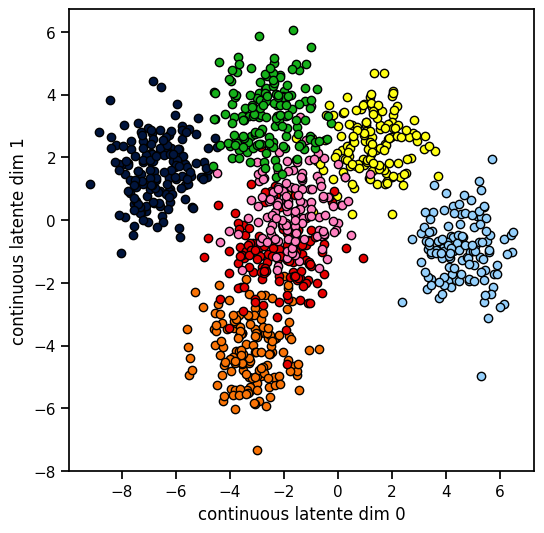

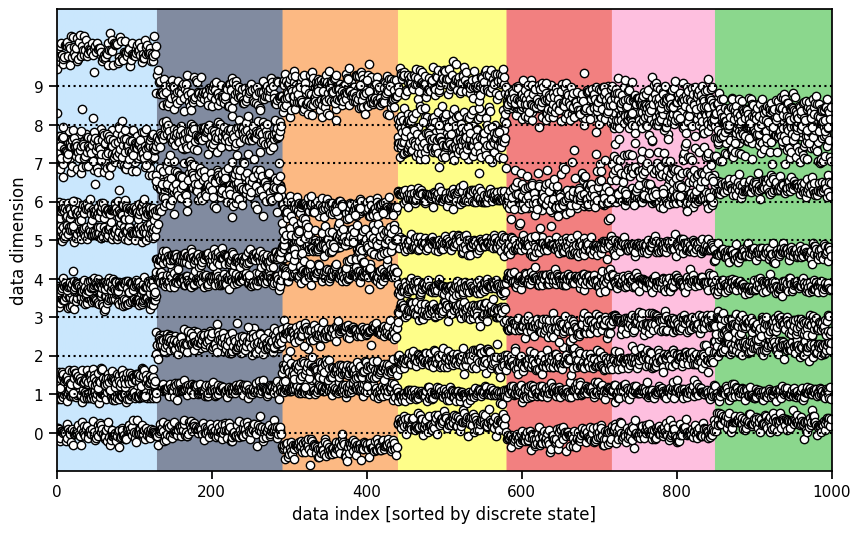

In [74]:
# Construct a model instance.
# The scale keyword determines how separated the clusters are in the continuous
# latent space.
torch.manual_seed(0)
num_states = 7
latent_dim = 2
data_dim = 10
model = MixtureOfFactorAnalyzers(num_states, latent_dim, data_dim, scale=3)

# Sample from the model
num_data = 1000
train_data = model.sample(sample_shape=(num_data,))
test_data = model.sample(sample_shape=(num_data,))

# Plot the data
model.plot(train_data)

## Part 1: Coordinate Ascent Variational Inference (CAVI)

First, we'll implement coordinate ascent variational inference (CAVI) for the mixture of factor analyzers model. We'll use a mean field posterior approximation

$$
\begin{align*}
p(z, x \mid y, \Theta) \approx \prod_{t=1}^T q(z_t) \, q(x_t)
\end{align*}
$$

such that $\mathrm{KL}\big( q(z)q(x) \, \| \, p(z, x \mid y, \Theta) \big)$ is minimized. In class, we showed how to minimize the KL via coordinate ascent, iteratively optimizing $q(z)$ and $q(x)$, holding the other fixed. Here we will implement that algorithm.

### Problem 1a [Math]: Derive the expected log likelihood

In class we derived the coordinate update for the discrete state factors,

$$
\begin{align*}
\log q(z_t) &= \mathbb{E}_{q(x_t)} \left[\log p(z_t, x_t, y \mid \Theta) \right] + \mathrm{c} \\
&= \mathbb{E}_{q(x_t)} \left[\log p(z_t \mid \Theta) + \log p(x_t \mid z_t, \Theta) + \log p(y \mid x_t, \Theta) \right] + \mathrm{c} \\
&= \log \mathrm{Cat}(z_t \mid \pi) + \mathbb{E}_{q(x_t)} \left[\log \mathcal{N}(x_t \mid b_{z_t}, Q_{z_t}) \right] + \mathrm{c} \\
&= \sum_{k=1}^K \mathbb{I}[z_t=k] \left( \log \pi_k + \mathbb{E}_{q(x_t)} \left[\log \mathcal{N}(x_t \mid b_k, Q_k) \right] \right) + \mathrm{c} \\
&= \log \mathrm{Cat}(z_t \mid \tilde{\pi}_t)
\end{align*}
$$

where

$$
\begin{align*}
\log \tilde{\pi}_{tk} = \log \pi_k + \underbrace{\mathbb{E}_{q(x_t)} \left[\log \mathcal{N}(x_t \mid b_k, Q_k) \right]}_{\text{expected log likelihood}} + \mathrm{c}.
\end{align*}
$$

However, we did not simplify the expected log likelihood expression.

Suppose $q(x_t) = \mathcal{N}(x_t \mid \tilde{\mu}_t, \tilde{\Sigma}_t)$. Show that the expected log likelihood is,

$$
\begin{align*}
\mathbb{E}_{q(x_t)} \left[\log \mathcal{N}(x_t \mid b_k, Q_k) \right]
&= \log \mathcal{N}(\tilde{\mu}_t \mid b_k, Q_k) - \tfrac{1}{2} \langle(Q_k^{-1}, \tilde{\Sigma}_t \rangle
\end{align*}
$$

_Your answer here_

### Problem 1b: Implement the discrete state update

We will use `torch.distributions.Distribution` objects to represent the  approximate posterior distributions as well. We will use `MultivariateNormal` to represent $q(x)$ and `Categorical` to represent $q(z)$. We'll take advantage of the distribution objects' broadcasting capability to represent the variational posteriors for all time steps at once.

_Implement a CAVI update for the discrete states posterior that takes in the model and the continuous state posterior `q_x` and outputs the optimal `q_z`._

In [75]:
def cavi_update_q_z(model, q_x):
    """Compute the optimal discrete state posterior given the generative model
    and the variational posterior on the continuous states.

    Parameters
    ----------
    model: a MixtureOfFactorAnalyzers model instance.

    q_x: a `MultivariateNormal` object with a shape `TxD` parameter `mean` and a
        shape `TxDxD` parameter `covariance matrix` representing the means and
        covariances, respectively, for each data point under the variational
        posterior.

    Returns
    -------
    q_z: a `Categorical` object with a shape `TxK` parameter `logits`
        representing the variational posterior on discrete states.
    """
    K = model.num_states
    T = q_x.mean.shape[0]

    logits = torch.zeros(T, K)
    ###
    # YOUR CODE BELOW

    log_pi = torch.log(model.pi)

    for k, (bk, Qk, Jk) in enumerate(zip(model.bs, model.Qs, model.Js)):

        diff  = q_x.mean - bk

        maha  = torch.sum((diff @ Qk) * diff, dim = 1)
        trace = torch.einsum('tij,ji->t', q_x.covariance_matrix, Qk)
        logdet = torch.slogdet(Qk)[1]

        logits[:, k] = (log_pi[k] + 0.5 * logdet - 0.5 * (maha + trace))

    ###
    return Categorical(logits=logits)


In [76]:
def test_1b():
    torch.manual_seed(0)
    q_x = MultivariateNormal(torch.randn(num_data, latent_dim),
                             torch.eye(latent_dim).repeat(num_data, 1, 1))
    q_z = cavi_update_q_z(model, q_x)
    assert q_z.probs.shape == (num_data, num_states)
    assert torch.isclose(q_z.probs.std(), torch.tensor(0.2576), atol=1e-4)
test_1b()

### Problem 1c: Implement the continuous state update

In class we showed that the optimal continuous state posterior, holding the discrete posterior fixed, was a Gaussian distribution $q(x_t) = \mathcal{N}(\tilde{\mu}_t, \tilde{\Sigma}_t)$ with

$$
\begin{align*}
\tilde{\mu}_t &= \tilde{J}_t^{-1} \tilde{h}_t &
\tilde{\Sigma}_t &= \tilde{J}_t^{-1} \\
\tilde{h}_t &= \mathbb{E}_{q({z_t})}[Q_{z_t}^{-1} b_{z_t}] + C^\top R^{-1} (y_t-d) &
\tilde{J}_t &= \mathbb{E}_{q({z_t})}[Q_{z_t}^{-1}] + C^\top R^{-1} C \\
&= \sum_{k=1}^K \left[ q({z_t}=k) Q_k^{-1} b_k \right] + C^\top R^{-1} (y_t-d) &
&= \sum_{k=1}^K \left[ q({z_t}=k) Q_k^{-1} \right] + C^\top R^{-1} C
\end{align*}
$$

_Implement a CAVI update for the continuous states posterior that takes in `p_x`, `p_y`, and `q_z` and outputs the optimal `q_x`._

In [79]:
def cavi_update_q_x(data, model, q_z):
    """Compute the optimal discrete state posterior given the generative model
    and the variational posterior on the continuous states.

    Parameters
    ----------
    data: a dictionary with a key `y` containing a `TxN` tensor of data.

    model: a MixtureOfFactorAnalyzers model instance.

    q_z: a `Categorical` object with a shape `TxK` parameters `logits` and
        `probs` representing the variational posterior on discrete states.

    Returns
    -------
    q_x: a `MultivariateNormal` object with a shape `TxD` parameter `mean` and a
        shape `TxDxD` parameter `covariance matrix` representing the means and
        covariances, respectively, for each data point under the variational
        posterior.
    """
    y = data["y"]

    ###
    # YOUR CODE BELOW

    T, N = y.shape
    K = model.num_states
    D = model.bs[0].shape[0]        # dimensionality of x

    # print(dir(model))

    # 1) build mixture‐weighted precision J and weighted “force” h
    J = torch.zeros(T, D, D, device=y.device)
    h = torch.zeros(T, D,    device=y.device)
    for k in range(K):
        Qk = model.Qs[k]           # (D, D)  precision of p(x|z=k)
        bk = model.bs[k]           # (D,)    mean of   p(x|z=k)
        w  = q_z.probs[:, k]       # (T,)
        J += w[:, None, None] * Qk
        h += w[:, None]        * (Qk @ bk)

    # 2) add the observation terms C^T R^{-1} C and C^T R^{-1}(y-d)
    Rinv = torch.diag(1.0 / model.R_diag)   # now Rinv is (N,N)
    J    = J + model.C.T @ Rinv @ model.C
    h    = h + (y - model.d) @ Rinv @ model.C

    Sigma = 0.5 * (Sigma + Sigma.transpose(-1, -2))

    max_tries = 5
    init_jitter = 1e-4

    # 3.b  adaptive diagonal jitter until Cholesky succeeds
    eye    = torch.eye(D, device=Sigma.device, dtype=Sigma.dtype)
    jitter = init_jitter
    for _ in range(max_tries):
        try:
            torch.linalg.cholesky(Sigma)                # will throw if not PD
            break                                       # success
        except RuntimeError:
            Sigma = Sigma + jitter * eye                # bump the diag
            jitter *= 10                                # grow the bump
    else:
        raise RuntimeError(
            "Failed to make covariance positive-definite after "
            f"{max_tries} attempts (last jitter = {jitter:e})."
        )

    mu = torch.einsum('tij,tj->ti', Sigma, h)           # (T, D)
    q_x = MultivariateNormal(loc=mu, covariance_matrix=Sigma)

    ###
    return q_x

In [80]:
def test_1c():
    torch.manual_seed(0)
    q_z = Categorical(logits=torch.randn(num_data, num_states))
    q_x = cavi_update_q_x(train_data, model, q_z)
    assert q_x.mean.shape == (num_data, latent_dim)
    assert q_x.covariance_matrix.shape == (num_data, latent_dim, latent_dim)
    assert torch.isclose(q_x.mean.mean(), torch.tensor(-0.7204), atol=1e-4)
    assert torch.isclose(q_x.mean.std(), torch.tensor(2.9253), atol=1e-4)
    assert torch.isclose(q_x.covariance_matrix.mean(), torch.tensor(0.0271), atol=1e-4)
    assert torch.isclose(q_x.covariance_matrix.std(), torch.tensor(0.0623), atol=1e-4)
test_1c()

### Problem 1d [Short Answer]: Intuition for the continuous updates

Consider setting the discrete posterior $q(z)$ to be uniform over the $K$ states and then performing one update of the continuous states. The plot below shows the true values of $x$ and $z$ as color coded dots in 2D, and then it shows the means of the continuous state posterior $q(x)$ found using one step of CAVI. We see that the means of the continuous state posterior are all pulled toward the center. Why would you expect that to happen?

---

_Your answer here_

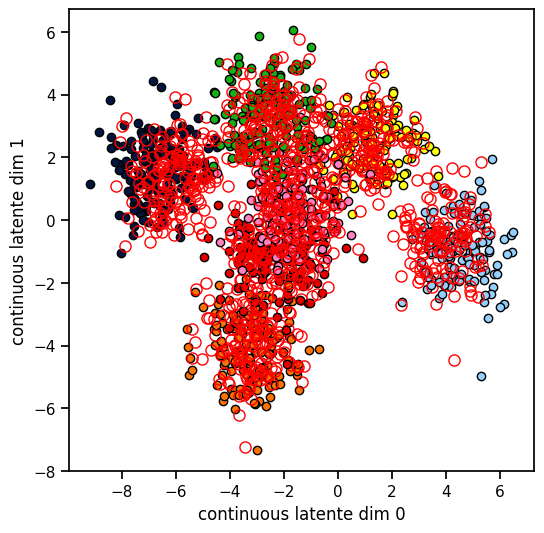

In [81]:
def plot_data_and_q_x(data, q_x):
    x, z, y = data['x'], data['z'], data['y']
    plt.figure(figsize=(6, 6))
    for k in range(model.num_states):
        plt.plot(x[z == k, 0], x[z == k, 1], 'o', color=palette[k], mec='k')
        plt.plot(q_x.mean[z == k, 0], q_x.mean[z == k, 1], 'o', color=palette[k], mfc='none', mec='r', ms=8)
    plt.xlabel("continuous latente dim 0")
    plt.ylabel("continuous latente dim 1")

q_z = Categorical(logits=torch.zeros(num_data, model.num_states))
q_x = cavi_update_q_x(train_data, model, q_z)
plot_data_and_q_x(train_data, q_x)

### Problem 1e [Math]: Derive the evidence lower bound

We will use the ELBO to track the convergence of our CAVI algorithm. In class we wrote the ELBO as,

$$
\begin{align*}
\mathcal{L}(q, \Theta) &= \mathbb{E}_{q(z)q(x)} \left[ \log p(z, x, y \mid \Theta) - \log q(z)q(x) \right]
\end{align*}
$$

Show that this is equivalent to,

$$
\begin{align*}
\mathcal{L}(q, \Theta)
&= \mathbb{E}_{q(x)}\left[\log p(y \mid x, \Theta) \right]
- \mathrm{KL}\big(q(z) \, \| \, p(z \mid \Theta) \big) - \mathbb{E}_{q(z)}\left[\mathrm{KL}\big( q(x) \, \| \, p(x \mid z, \Theta) \big) \right].
\end{align*}
$$

Then show that,

$$
\begin{align*}
\mathbb{E}_{q(x)}\left[\log p(y \mid x, \Theta) \right]
&= \sum_{t=1}^T \log \mathcal{N}(y_t \mid C \tilde{\mu}_t + d, R) -\tfrac{1}{2} \langle C^\top R^{-1} C, \tilde{\Sigma}_t \rangle,
\end{align*}
$$

where $\tilde{\mu}_t$ and $\tilde{\Sigma}_t$ are the parameters of the variational posterior $q(x_t)$, as above.

---

_Your answer here_

### Problem 1f: Implement the ELBO

Use the `IndependentLinearRegression.log_prob` function and the `torch.distributions.kl_divergence` function imported at the top of the notebook to implement the ELBO calculation. Remember that the log probabilities and KL divergence functions broadcast nicely.

In [ ]:
import math

In [82]:
def elbo(data, model, variational_posterior):
    """Compute the optimal discrete state posterior given the generative model
    and the variational posterior on the continuous states.

    Parameters
    ----------
    data: a dictionary with a key `y` containing a `TxN` tensor of data.

    model: a MixtureOfFactorAnalyzers model instance

    variational_posterior: a tuple (q_z, q_x) where
        q_z: a `Categorical` object with a shape `TxK` parameter `logits`
            representing the variational posterior on discrete states.

        q_x: a `MultivariateNormal` object with a shape `TxD` parameter `mean`
            and a shape `TxDxD` parameter `covariance matrix` representing the
            means and covariances, respectively, for each data point under the
            variational posterior.

    Returns
    -------
    The evidence lower bound (ELBO) as derived above.
    """
    y = data["y"]
    q_z, q_x = variational_posterior

    ###
    # YOUR CODE BELOW


    # ------------------------------------------------------------------
    # 1.  E_q(x)[log p(y|x,Θ)]
    # ------------------------------------------------------------------
    T, N        = y.shape
    D           = q_x.mean.shape[1]

    # Predicted mean of y under q(x)
    y_hat       = q_x.mean @ model.C.T + model.d          # (T, N)
    resid       = y - y_hat                               # (T, N)

    R_diag      = model.R_diag                            # (N,)
    logdet_R    = torch.sum(torch.log(R_diag))            # scalar

    const       = -0.5 * (N * math.log(2 * math.pi) + logdet_R)
    ll_mean     = const - 0.5 * torch.sum(resid**2 / R_diag, dim=1)  # (T,)

    # Trace term  -½⟨CᵀR⁻¹C , Σ̃_t⟩
    R_inv       = torch.diag(1.0 / R_diag)                # (N, N)
    G           = model.C.T @ (R_inv @ model.C)           # (D, D)
    trace_term  = -0.5 * torch.einsum("ij,tij->t", G, q_x.covariance_matrix)

    expected_log_like = (ll_mean + trace_term).sum()      # scalar

    # ------------------------------------------------------------------
    # 2.  − KL(q(z) || p(z|Θ))
    # ------------------------------------------------------------------
    p_z         = Categorical(probs=model.pi)             # (K,)
    kl_z        = kl_divergence(q_z, p_z).sum()           # scalar

    # ------------------------------------------------------------------
    # 3.  − E_q(z)[KL(q(x) || p(x|z,Θ))]
    # ------------------------------------------------------------------
    kl_x_all = []
    for k in range(model.num_states):
        p_x_k  = MultivariateNormal(loc=model.bs[k],
                                    precision_matrix=model.Qs[k])
        kl_k   = kl_divergence(q_x, p_x_k)                # (T,)
        kl_x_all.append(kl_k)
    kl_x_all   = torch.stack(kl_x_all, dim=1)             # (T, K)
    kl_x       = (q_z.probs * kl_x_all).sum()             # scalar

    # ------------------------------------------------------------------
    elbo = expected_log_like - kl_z - kl_x
    # ------------------------------------------------------------------

    ###
    return elbo


In [83]:
def test_1f():
    q_z = Categorical(logits=torch.zeros(num_data, model.num_states))
    q_x = cavi_update_q_x(train_data, model, q_z)
    assert torch.isclose(elbo(train_data, model, (q_z, q_x)) / num_data,
                         torch.tensor(-32.3214), atol=1e-4)

test_1f()

### Problem 1g [Math]: Derive the exact marginal likelihood

In this simple model, we can actually compute the marginal likelihood exactly. This gives us a way of seeing how tight the ELBO actually is. (Remember, the ELBO is a lower bound on the marginal likelihood!)

To compute the marginal likelihood, we need two key facts about Gaussian random variables:

$$
\begin{align*}
x \sim \mathcal{N}(b, Q) &\implies C x + d \sim \mathcal{N}(Cb + d, CQ C^\top) \\
m \sim \mathcal{N}(\mu_1, \Sigma_1),
\epsilon \sim \mathcal{N}(\mu_2, \Sigma_2) &\implies
m + \epsilon \sim \mathcal{N}(\mu_1 + \mu_2, \Sigma_1 + \Sigma_2)
\end{align*}
$$

Use these two facts to show that

$$
\begin{align*}
p(y_t \mid z_t, \Theta) &= \mathcal{N}(C b_{z_t} + d, C Q_{z_t} C^\top + R).
\end{align*}
$$

Then show that

$$
\begin{align*}
\log p(y \mid \Theta) &= \sum_{t=1}^T \log \left( \sum_{k=1}^K \pi_{k} \, \mathcal{N}(y_t \mid C b_{k} + d, C Q_{k} C^\top + R) \right).
\end{align*}
$$

---


_Your answer here_


### Implement the exact marginal likelihood
The code below implements the exact marginal likelihood according to the formula above using PyTorch's `LowRankMultivariateNormal` distribution. Note: this distribution takes in the square root of $C Q_k C^\top$, which is $C Q_k^{1/2}$.

In [84]:
def exact_marginal_lkhd(data, model):
    """
    Compute the exact marginal likelihood.
    Normalize by the number of datapoints.
    """
    # Compute the marginal distributions
    y = data["y"]
    T = y.shape[0]
    K = model.num_states

    # Compute the marginal likelihood under each discrete state assignment
    lls = torch.zeros(T, K)
    for k, (bk, Qk) in enumerate(zip(model.bs, model.Qs)):
        # log p(z = k)
        lls[:, k] += model.log_pi[k]

        # logp(y | z = k) = log N(y | C b_k + d, C Q_k C^T + diag(R))
        Qk_sqrt = torch.linalg.cholesky(Qk)
        p_yk = LowRankMultivariateNormal(model.C @ bk + model.d,
                                         model.C @ Qk_sqrt, model.R_diag)
        lls[:, k] += p_yk.log_prob(y)

    return torch.logsumexp(lls, axis=1).sum()

marginal_ll = exact_marginal_lkhd(train_data, model) / num_data

### Run CAVI

That's all we need for CAVI! The code below simply alternates between updating $q(z)$ and $q(x)$. After each iteration, we compute the ELBO.We allow the user to pass in an initial posterior approximation (though only $q(z)$ is used since $q(x)$ is immediately updated).

In [85]:
def cavi(data, model, initial_posterior=None, num_steps=10, pbar=None):
    y = data["y"]

    # Initialize the discrete state posterior to uniform
    if initial_posterior is None:
        q_z = Categorical(logits=torch.zeros(len(y), model.num_states))
        q_x = None
    else:
        q_z, _ = initial_posterior

    # Optional progress bar
    if pbar is not None: pbar.reset()

    # Run CAVI
    avg_elbos = []
    for i in range(num_steps):
        if pbar is not None: pbar.update()
        q_x = cavi_update_q_x(data, model, q_z)
        avg_elbos.append(elbo(data, model, (q_z, q_x)) / len(y))
        q_z = cavi_update_q_z(model, q_x)

    return torch.tensor(avg_elbos), (q_z, q_x)

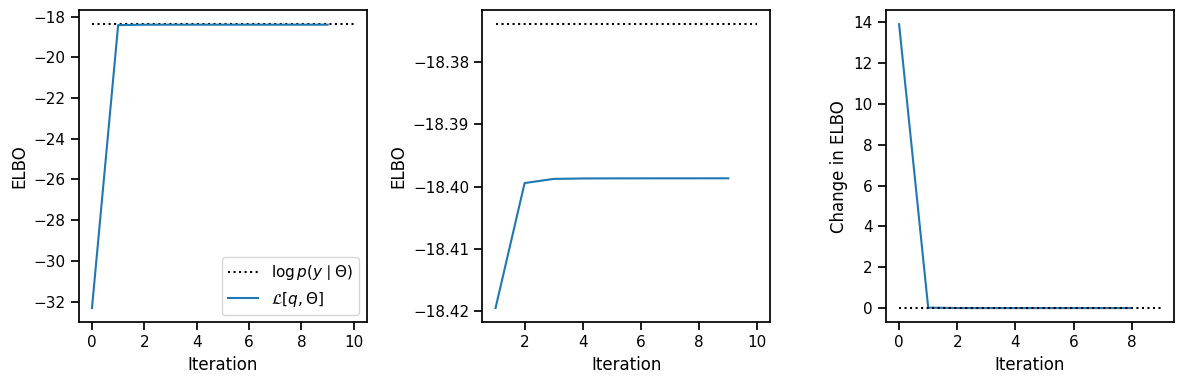

In [86]:
# Run CAVI and plot the ELBO over coordinate ascent iterations
avg_elbos, (q_z, q_x) = cavi(train_data, model)
plot_elbos(avg_elbos, marginal_ll)

### Re-examine the continuous state posterior after CAVI

Now let's make the same plot from Problem 1d again. We should see that the continuous means are pulled toward their true values. Remember, these are inferences! The CAVI algorithm only sees the data $y$ and the model parameters $\Theta$. After a few iterations (really, after about 2 iterations), it converges to a posterior approximation in which the mean of continuous latent states, $\mathbb{E}_{q(x_t)}[x_t]$, are close to their true values.

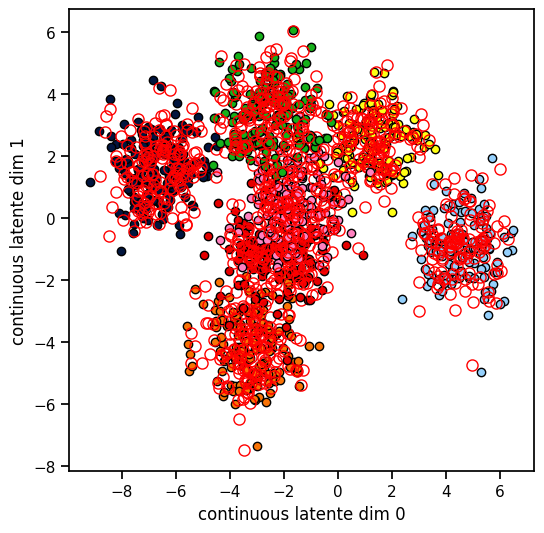

In [87]:
plot_data_and_q_x(train_data, q_x)

## Part 2: Variational EM in a mixture of factor analysis models

The CAVI algorithm we implemented in Part 1 will form the E step for variational EM. To complete the algorithm, we just need to compute the expected sufficient statistics under the variational posterior and use them to implement the M-step. Last week, in Lab 7, we derived the expected sufficient statistics needed to update the multivariate normal distribution and the weights of the linear regression. In this part, you'll write similar functions to compute the expected sufficient statistics using the variational posterior.


### Problem 2a: Compute the expected sufficient statistics


The sufficient statistics of the model are (with zero-indexing for Python friendliness),

0. $\sum_{t=1}^T \mathbb{I}[z_t=k]$ for $k = 1, \ldots, K$
1. $\sum_{t=1}^T \mathbb{I}[z_t=k] \, x_t$ for $k = 1, \ldots, K$
2. $\sum_{t=1}^T \mathbb{I}[z_t=k] \, x_t x_t^\top$ for $k = 1, \ldots, K$
3.  $\sum_{t=1}^T x_t$
4. $\sum_{t=1}^T x_t x_t^\top$
5. $\sum_{t=1}^T y_t x_t^\top$
6. $\sum_{t=1}^T y_t$
7. $\sum_{t=1}^T y_t^2$
7. $\sum_{t=1}^T 1 = T$

Write a function that computes the _expected_ sufficient statistics $\mathbb{E}_{q(z)q(x)}[\cdot]$ under the variational posterior distribution. In code, we'll call these variables `E_*`, for example `E_z` represents the length $K$ tensor for the sufficient statistic 0.

**Note:** The expected outer product, $\mathbb{E}_{q(x_t)}[x_t x_t^\top]$, does _not_ equal the covariance matrix unless $\mathbb{E}_{q(x_t)}[x_t]$ is zero (and here, it's not generally zero).

**Note:** Statistics 3 and 1 are redundant, as are 4 and 2. We've split them out anyway, as they are used separately in updating the parameters of `p_x` and `p_y`.

In [88]:
def compute_expected_suffstats(data, posterior):
    """
    Compute the expected sufficient statistics of the data
    under the variational posterior

    Parameters
    ----------
    data: a dictionary with a key `y` containing a `TxN` tensor of data.
    posterior: a tuple (q_z, q_x) representing the variational posterior, as
        computed in part 1.

    Returns
    -------
    A tuple of the 9 expected sufficient statistics in the order listed above.
    """
    y = data["y"]
    q_z, q_x = posterior

    # ---------- expectations under q(x) ----------
    mu        = q_x.mean                 # (T, D)
    Sigma     = q_x.covariance_matrix    # (T, D, D)
    E_xx_full = Sigma + torch.einsum("ti,tj->tij", mu, mu)   # (T, D, D)

    # ---------- helper constants ----------
    probs     = q_z.probs                # (T, K)
    T_val     = y.shape[0]               # scalar (python int)

    # ---------- 0.  Σ_t 1[z_t = k] ----------
    E_z       = probs.sum(dim=0)                              # (K,)

    # ---------- 1.  Σ_t 1[z_t = k] x_t ----------
    E_zx      = torch.einsum("tk,td->kd", probs, mu)          # (K, D)

    # ---------- 2.  Σ_t 1[z_t = k] x_t x_tᵀ ----------
    E_zxxT    = torch.einsum("tk,tij->kij", probs, E_xx_full) # (K, D, D)

    # ---------- 3.  Σ_t x_t ----------
    E_x       = mu.sum(dim=0)                                 # (D,)

    # ---------- 4.  Σ_t x_t x_tᵀ ----------
    E_xxT     = E_xx_full.sum(dim=0)                          # (D, D)

    # ---------- 5.  Σ_t y_t x_tᵀ ----------
    E_yxT     = torch.einsum("tn,td->nd", y, mu)              # (N, D)

    # ---------- 6.  Σ_t y_t ----------
    E_y       = y.sum(dim=0)                                  # (N,)

    # ---------- 7.  Σ_t y_t² ----------
    E_ysq     = (y**2).sum(dim=0)                             # (N,)

    # ---------- 8.  Σ_t 1  (just T) ----------
    T         = y.shape[0]        # ()

    return (E_z, E_zx, E_zxxT, E_x, E_xxT, E_yxT, E_y, E_ysq, T)

In [89]:
def test_2a():
    print("This test only checks the shapes, not the values!")
    stats = compute_expected_suffstats(train_data, (q_z, q_x))
    assert len(stats) == 9
    E_z, E_zx, E_zxxT, E_x, E_xxT, E_yxT, E_y, E_ysq, T = stats
    assert E_z.shape == (num_states,)
    assert E_zx.shape == (num_states, latent_dim)
    assert E_zxxT.shape == (num_states, latent_dim, latent_dim)
    assert E_x.shape == (latent_dim,)
    assert E_xxT.shape == (latent_dim, latent_dim)
    assert E_yxT.shape == (data_dim, latent_dim)
    assert E_y.shape == (data_dim,)
    assert E_ysq.shape == (data_dim,)
    assert isinstance(T, (int, float))

test_2a()

This test only checks the shapes, not the values!


### Problem 2b: Implement the M-step for the parameters of $p(z \mid \Theta)$

Write a function to update the prior distribution on discrete states, $p(z \mid \Theta)$, using the expected sufficient statistics. This is part of the M-step for variational EM.

In [90]:
def update_p_z(stats):
    """
    Compute the parameters $\pi$ of the $p(z \mid \Theta)$ and pack them into
    a new Categorical distribution object.

    Parameters
    ----------
    stats: a tuple of the 9 sufficient statistics computed above

    Returns
    -------
    A new Categorical object for p_z with a length K tensor of cluster
        probabilities.
    """
    E_z = stats[0]
    ###
    # YOUR CODE BELOW

    T   = stats[-1]         # Python int – total number of data points

    # Convert T to a tensor on the same device/dtype as E_z for safe division
    T   = torch.as_tensor(T, dtype=E_z.dtype, device=E_z.device)

    # Maximum-likelihood (or MAP with a flat Dirichlet) estimate of π
    pi  = E_z / T           # (K,), guaranteed to sum to 1 because Σ_k E_z[k] = T

    # Numerical safety: ensure pi is strictly positive and renormalize
    eps = 1e-12
    pi  = (pi + eps) / (pi + eps).sum()

    p_z = Categorical(probs=pi)

    ###
    return p_z

### Problem 2c: Implement the M-step for parameters of $p(x \mid z, \Theta)$

Perform an M-step on the parameters of $p(x \mid z, \Theta)$ using the expected sufficient statistics. As before, add a little to the diagonal of the covariance to ensure positive definiteness.

In [91]:
def update_p_x(stats):
    """
    Compute the parameters $\{b_k, Q_k\}$ of the $p(x \mid z, \Theta)$ and pack
    them into a new MultivariateNormal distribution object.

    Parameters
    ----------
    stats: a tuple of the 9 sufficient statistics computed above

    Returns
    -------
    A new MultivariateNormal object with KxD mean and KxDxD covariance matrix.
    """
    E_z, E_zx, E_zxxT = stats[:3]
    K, D = E_zx.shape

    ###
    # YOUR CODE BELOW

    jitter = 1e-4

    # ------------------------------------------------------------------
    # 1.  Component weights / counts
    # ------------------------------------------------------------------
    N_k = E_z.clamp_min(1e-12)             # avoid divide-by-zero

    # ------------------------------------------------------------------
    # 2.  Means  b_k  =  Σ_t q(z_t=k) x_t   /   Σ_t q(z_t=k)
    # ------------------------------------------------------------------
    b_k = E_zx / N_k.unsqueeze(-1)         # (K, D)

    # ------------------------------------------------------------------
    # 3.  Covariances
    #     Σ_k =  Σ_t q(z_t=k) x_t x_tᵀ  / N_k  −  b_k b_kᵀ
    # ------------------------------------------------------------------
    E_xx_k   = E_zxxT / N_k.view(K, 1, 1)                    # (K,D,D)
    outer_bb = torch.einsum("kd,ke->kde", b_k, b_k)          # (K,D,D)
    Sigma_k  = E_xx_k - outer_bb

    # add a tiny jitter for positive-definiteness
    eye      = torch.eye(D, device=Sigma_k.device, dtype=Sigma_k.dtype)
    Sigma_k  = Sigma_k + jitter * eye.expand(K, D, D)

    # ------------------------------------------------------------------
    p_x = MultivariateNormal(loc=b_k, covariance_matrix=Sigma_k)
    # ------------------------------------------------------------------

    #
    ###
    return p_x

### Problem 2d: Implement the M-step for parameters of $p(y \mid x, \Theta)$

Following Lab 7, let $\phi_t = (x_t, 1)$ denote the covariates that go into the linear model for data point $y_t$. Specifically,

$$
\begin{align*}
p(y_t \mid x_t, \Theta) &= \mathcal{N}(y_t \mid W \phi_t, R),
\end{align*}
$$

where $W = (C, d) \in \mathbb{R}^{N \times D+1}$ is an array containing both the weights and the bias of the linear regression model.

To update the linear regression, we need the expected sufficient statistics:
- The expected outer product of the data and covariates,

$$
\begin{align*}
\mathbb{E}_{q(x_t)}[ y \phi_t^\top] = \mathbb{E}_{q(x_t)}[ y (x_t, 1)^\top]
= \begin{bmatrix} \mathbb{E}_{q(x_t)}[ y x_t^\top], & y \end{bmatrix}
\end{align*}
$$

- The expected outer product of the covariates with themselves,

$$
\begin{align*}
\mathbb{E}_{q(x_t)}[ \phi_t \phi_t^\top] = \mathbb{E}_{q(x_t)}[ (x_t, 1) (x_t, 1)^\top]
= \begin{bmatrix} \mathbb{E}_{q(x_t)}[ x_t x_t^\top], &  \mathbb{E}_{q(x_t)}[ x_t] \\
\mathbb{E}_{q(x_t)}[x_t^\top], & T
\end{bmatrix}
\end{align*}
$$

These are $N \times (D+1)$ and $(D+1) \times (D+1)$ tensors, respectively.

Since we are assuming a diagonal covariance matrix, we only need $y_{tn}^2$ instead of the full outer product $y_t y_t^\top$.  As before, add a bit to the diagonal to ensure positive definiteness.

In [92]:
from torch.distributions import Independent, Normal

In [97]:
def update_p_y(stats):
    """
    Compute the linear regression parameters given the expected
    sufficient statistics.

    Note: add a little bit to the diagonal of each covariance
        matrix to ensure that the result is positive definite.

    Parameters
    ----------
    stats: a tuple of the 8 sufficient statistics computed above

    Returns
    -------
    A new IndependentLinearRegression object for p_y
    """
    E_x, E_xxT, E_yxT, E_y, E_ysq, T = stats[3:]
    N, D = E_yxT.shape

    ###
    # Use E_x, E_xxT, E_yxT, E_y, and T to compute the full expected
    # sufficient matrices as described above.
    #
    # YOUR CODE BELOE

    jitter = 1e-4

    E_x, E_xxT, E_yxT, E_y, E_ysq, T = stats[3:]     # unpack
    N, D  = E_yxT.shape
    T     = torch.as_tensor(T, dtype=E_x.dtype, device=E_x.device)

    # ----- build normal-equation blocks (all in one go) --------------------
    S_phi_phi = torch.cat([
        torch.cat([E_xxT, E_x.unsqueeze(1)], dim=1),
        torch.cat([E_x.unsqueeze(0), T.view(1, 1)], dim=1)   # 👈  key change
    ], dim=0)                                             # (D+1, D+1)
    S_phi_phi += jitter * torch.eye(D+1, device=E_x.device)


    S_y_phi   = torch.cat([E_yxT, E_y[:, None]], dim=1)  # (N, D+1)

    # ----- solve for W = [C | d] ---------------------------
    #   W = S_yφ · (S_φφ)⁻¹  -> use 'solve' to avoid explicit inverse
    W = torch.linalg.solve(S_phi_phi.T, S_y_phi.T).T      # (N, D+1)
    C, d = W[:, :D], W[:, D]

    # ----- residual variances (all vectorised) -------------
    # term1 = E[y²]                     (N,)
    term1 = E_ysq
    # term2 = 2 * w · S_yφ              (N,)
    term2 = 2 * (W * S_y_phi).sum(dim=1)
    # term3 = w · S_φφ · w              (N,)
    term3 = (W @ S_phi_phi * W).sum(dim=1)

    R_diag = (term1 - term2 + term3) / T
    R_diag = R_diag.clamp_min(jitter)

    p_y = IndependentLinearRegression(C, d, R_diag)



    #
    ###

    return p_y

### Put it all together

From here it's smooth sailing! We just iterate between the variational E step, which involves running CAVI for some number of iterations, and then performing an M step using expected sufficient statistics. We'll track the ELBO throughout to monitor convergence.

In [98]:
def m_step(data, model, posterior):
    """
    Perform an M-step to update the model parameters given the data and the
    posterior from the variational E step.
    """
    stats = compute_expected_suffstats(data, posterior)
    model.p_z = update_p_z(stats)
    model.p_x = update_p_x(stats)
    model.p_y = update_p_y(stats)


def variational_em(data, model, num_iters=100, num_cavi_steps=1):
    """
    Fit the model parameters via variational EM.
    """
    # Run CAVI
    avg_elbos = []
    posterior = None
    for i in trange(num_iters):
        # Variational E step with CAVI
        these_elbos, posterior = cavi(data, model, posterior,
                                      num_steps=num_cavi_steps)
        avg_elbos.extend(these_elbos)

        # M-step
        m_step(data, model, posterior)

    return torch.tensor(avg_elbos), posterior


  0%|          | 0/100 [00:00<?, ?it/s]

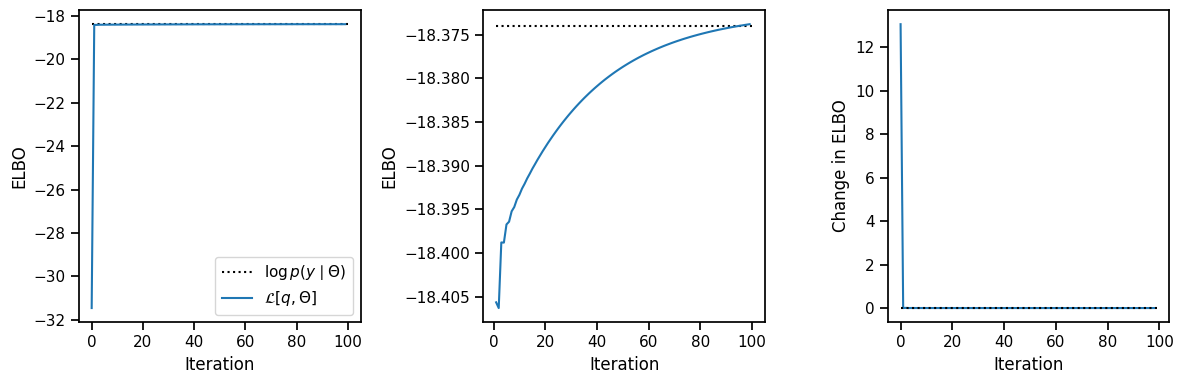

In [99]:
# Fit the synthetic data
avg_elbos, posterior = variational_em(train_data, model)
plot_elbos(avg_elbos, marginal_ll)

### Problem 2e [Short Answer]: Interpret the results

One perhaps counterintuitive aspect of the output is that the ELBO of the fitted model actually exceeds the marginal likeliood of the true model. How can that happen?

_Answer below this line_

----

### Problem 2f: Cross validation

Fit the MFA model with variational EM for $D=1,\ldots, 5$ (inclusive), keeping the number of discrete states fixed to $K=7$. For each model, evaluate the evidence lower bound on the test data, using ten steps of CAVI to approximate the posterior. Then compute the exact marginal likelihood using the true model and compare.

In [100]:
test_latent_dims = torch.arange(1, 11)
test_elbos = []
for d in test_latent_dims:
    print("Fitting the MFA model with D =", int(d),
          "dimensional continuous states.")
    ###
    # YOUR CODE BELOW
    # ...


    # 1.  fresh MFA with K = 7 and latent dim = d
    test_model = MixtureOfFactorAnalyzers(
        num_states=7,
        data_dim=data_dim,
        latent_dim=int(d)
    )

    # 2.  fit on the training data by variational-EM
    _ , _ = variational_em(train_data, test_model,
                           num_iters=100, num_cavi_steps=1)

    # 3.  approximate posterior on the *test* data (10 CAVI steps)
    _ , test_posterior = cavi(test_data, test_model,
                              initial_posterior=None,   # <- correct keyword
                              num_steps=10)

    # 4.  compute per-datum ELBO on the test set and store
    test_elbo = elbo(test_data, test_model, test_posterior)
    test_elbos.append(test_elbo / test_data["y"].shape[0])

    #
    ###

# Compute the true marginal likelihood of the test dat
true_test_elbo = exact_marginal_lkhd(test_data, model) / num_data

# Plot as a function of continuous dimensionality
plt.plot(test_latent_dims, test_elbos, '-o')
plt.plot(test_latent_dims, true_test_elbo * torch.ones_like(test_latent_dims), ':k')
plt.xlabel("continuous dimension $D$")
plt.ylabel("Test ELBO")

Fitting the MFA model with D = 1 dimensional continuous states.


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting the MFA model with D = 2 dimensional continuous states.


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting the MFA model with D = 3 dimensional continuous states.


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting the MFA model with D = 4 dimensional continuous states.


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting the MFA model with D = 5 dimensional continuous states.


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting the MFA model with D = 6 dimensional continuous states.


  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Expected parameter covariance_matrix (Tensor of shape (1000, 6, 6)) of distribution MultivariateNormal(loc: torch.Size([1000, 6]), covariance_matrix: torch.Size([1000, 6, 6])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[[ 0.3226, -0.1372, -0.0631,  0.2226, -0.0275,  0.1833],
         [-0.1372,  0.3989, -0.0977,  0.0675, -0.2711, -0.0172],
         [-0.0631, -0.0977,  0.7115, -0.0915, -0.1564, -0.1148],
         [ 0.2226,  0.0675, -0.0915,  0.6499, -0.0778, -0.2070],
         [-0.0275, -0.2711, -0.1564, -0.0778,  0.3896, -0.1260],
         [ 0.1833, -0.0172, -0.1148, -0.2070, -0.1260,  0.5297]],

        [[ 0.3210, -0.1381, -0.0635,  0.2238, -0.0246,  0.1783],
         [-0.1381,  0.4031, -0.1002,  0.0678, -0.2741, -0.0153],
         [-0.0635, -0.1002,  0.7153, -0.0933, -0.1552, -0.1155],
         [ 0.2238,  0.0678, -0.0933,  0.6569, -0.0767, -0.2124],
         [-0.0246, -0.2741, -0.1552, -0.0767,  0.3903, -0.1251],
         [ 0.1783, -0.0153, -0.1155, -0.2124, -0.1251,  0.5284]],

        [[ 0.3211, -0.1368, -0.0628,  0.2220, -0.0270,  0.1817],
         [-0.1368,  0.4010, -0.0997,  0.0692, -0.2726, -0.0163],
         [-0.0628, -0.0997,  0.7128, -0.0916, -0.1549, -0.1155],
         [ 0.2220,  0.0692, -0.0916,  0.6515, -0.0786, -0.2093],
         [-0.0270, -0.2726, -0.1549, -0.0786,  0.3901, -0.1259],
         [ 0.1817, -0.0163, -0.1155, -0.2093, -0.1259,  0.5300]],

        ...,

        [[ 0.3227, -0.1393, -0.0623,  0.2254, -0.0248,  0.1786],
         [-0.1393,  0.4052, -0.1017,  0.0664, -0.2752, -0.0144],
         [-0.0623, -0.1017,  0.7157, -0.0914, -0.1543, -0.1161],
         [ 0.2254,  0.0664, -0.0914,  0.6575, -0.0770, -0.2117],
         [-0.0248, -0.2752, -0.1543, -0.0770,  0.3912, -0.1259],
         [ 0.1786, -0.0144, -0.1161, -0.2117, -0.1259,  0.5289]],

        [[ 0.3228, -0.1372, -0.0628,  0.2226, -0.0277,  0.1836],
         [-0.1372,  0.3992, -0.0981,  0.0676, -0.2713, -0.0171],
         [-0.0628, -0.0981,  0.7114, -0.0910, -0.1561, -0.1150],
         [ 0.2226,  0.0676, -0.0910,  0.6495, -0.0781, -0.2068],
         [-0.0277, -0.2713, -0.1561, -0.0782,  0.3897, -0.1262],
         [ 0.1836, -0.0171, -0.1150, -0.2068, -0.1262,  0.5300]],

        [[ 0.3176, -0.1353, -0.0646,  0.2201, -0.0254,  0.1787],
         [-0.1353,  0.4003, -0.0992,  0.0718, -0.2727, -0.0164],
         [-0.0646, -0.0992,  0.7141, -0.0952, -0.1553, -0.1151],
         [ 0.2201,  0.0718, -0.0952,  0.6542, -0.0779, -0.2130],
         [-0.0254, -0.2727, -0.1553, -0.0779,  0.3893, -0.1243],
         [ 0.1787, -0.0164, -0.1151, -0.2130, -0.1243,  0.5287]]])

### Problem 2g [Short answer]: Interpret the results

Would you be surprised to see the fitted models achieve higher ELBOs on test data than the marginal likelihod of the true model? Can you think of any potential concerns with using the ELBO for model comparison; e.g. for selecting the latent state dimension $D$?

----

_Your answer here_

## Part 3: Apply it to real data

Finally, we'll apply the mixture of factor analyzers to calcium imaging data from immobilized worms studied by Kato et al (2015). They also segmented the time series into discrete states based on the neural activity and gave each state a name, using their knowledge of how different neurons correlate with different types of behavior. We'll try to recapitulate some of their results using the MFA model to infer discrete states.

In [ ]:
%%capture
!wget -nc https://github.com/slinderman/ml4nd/raw/refs/heads/main/data/07_vem/kato2015.zip
!unzip -n kato2015.zip

### Load the data

The data is stored in a dictionary with a few extra keys for the neuron names and the given discrete state labels and human-interpretable state names.

In [ ]:
# Load the data for a single worm
data = load_kato(index=4)

# Extract key constants
num_frames, num_neurons = data["y"].shape
times = torch.arange(num_frames) / data["fps"]

print(data.keys())

### Perform PCA

We'll use the principal components for visualization as well as for finding a permutation of the neurons that puts similar neurons, as measured by their loading on the first principal component, near to one another.

In [ ]:
# Perform PCA
pca = PCA(20)
data["pcs"] = pca.fit_transform(data["y"])
neuron_perm = torch.argsort(torch.tensor(pca.components_[0]))

### Plot the data
We plot the time series of neural activity on top of the color-coded discrete states given by Kato et al. You should see that the different discrete states correspond to different levels of neural activity across the population of neurons.

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(data["z_kato"][None, :], extent=(0, times[-1], -1, num_neurons + 2),
           alpha=0.5, cmap=cmap, aspect="auto")
plt.plot(times, data["y"][:, neuron_perm] + torch.arange(num_neurons), '-k', lw=1)
plt.xlabel("time[s]")
plt.ylabel("neurons")
plt.yticks(torch.arange(num_neurons),
           [data["neuron_names"][i] for i in neuron_perm],
           fontsize=10)
plt.ylim(-1, num_neurons+2)

for state_name, color in zip(data["state_names"], palette):
    plt.plot([torch.nan], [torch.nan], '-', color=color, lw=4, label=state_name)

plt.legend(loc="lower right", ncol=2)

### Plot the PCA trajectories

We can also visualize the population activity as a trajectory through PCA space. Here we plot the trajectory in planes spanned by pairs of principal components. We color code the trajectory based on the given discrete states.

**Note**: We smoothed the trajectories a bit to make the visualization nicer.

**Note**: These differ from the figures in Kato et al (2015) in that they used PCA on the first order differences in neural activity (akin to the "spikes" in the calcium trace, even though _C elegans_ doesn't fire action potentials). We found that the first order differences didn't cluster as nicely with the MFA model, so we are working with the calcium traces directly.

In [ ]:
pcs_smooth = gaussian_filter1d(data["pcs"], 1, axis=0)

fig, axs = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)
for i in range(4):
    for j in range(i+1, 5):
        plot_2d_continuous_states(pcs_smooth, data["z_kato"],
                                  ax=axs[j-1, i], inds=(i, j), lw=1)
        axs[j-1, i].set_xlabel("PC{}".format(i))
        axs[j-1, i].set_ylabel("PC{}".format(j))

    for j in range(i):
        axs[j, i].set_axis_off()

for state_name, color in zip(data["state_names"], palette):
    axs[0, -1].plot([torch.nan], [torch.nan], '-',
                    color=color, lw=4, label=state_name)
axs[0, -1].legend(loc="upper right", ncol=2, )

plt.tight_layout()

### Problem 3a [Short Answer]: Interpret the PCA trajectories

What can you say about the cycle of neural activity in this worm given the PCA trajectories and the state labels provided by Kato et al (2015)?

_Answer below this line_

---

### Fit the mixture of factor analyzers

Now fit the model. We'll give it twice as many states as Kato et al (2015) did. This often helps avoid some local optima where states are unused. We'll use ten dimensional continuous latents, as they do in the paper.

In [ ]:
# Fit the worm data
torch.manual_seed(0)
num_states = 16
latent_dim = 10
worm_model = MixtureOfFactorAnalyzers(num_states, latent_dim, num_neurons)

# Fit the model!
avg_elbos, posterior = variational_em(data, worm_model,
                                      num_iters=100,
                                      num_cavi_steps=1)

plot_elbos(avg_elbos)

### Compute the overlap between the given and inferred discrete states

In [ ]:
# Find the most likely state segmentation
q_z, q_x = posterior
z_inf = q_z.probs.argmax(axis=1)

# compute overlap with the manually labeled states
overlap = torch.zeros(8, num_states)
for i in range(8):
    for j in range(num_states):
        overlap[i, j] = torch.sum((data["z_kato"] == i) * (z_inf == j))

# normalize since sum given states are used less frequently than others
overlap /= overlap.sum(axis=0)

# permute the inferred labels for easier visualization
z_perm = torch.argsort(torch.argmax(overlap, axis=0))

# show the permuted overlap matrix
plt.imshow(overlap[:, z_perm])
plt.ylabel("Kato et al labels")
plt.yticks(torch.arange(8), data["state_names"])
plt.xlabel("inferred discrete states")
plt.title("overlap (column normalized)")
plt.colorbar()

# Permute the inferred discrete states per the new ordering
z_inf_perm = torch.argsort(z_perm)[z_inf]

### Plot the inferred segmentation and the given state labels

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20, 11),
                        gridspec_kw=dict(height_ratios=[1, 10]),
                        sharex=True)

axs[0].imshow(data["z_kato"][None, :],
              extent=(0, times[-1], 0, 1),
              alpha=0.8, cmap=cmap, aspect="auto")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_ylabel("$z_{\mathsf{Kato}}$")

axs[1].imshow(z_inf_perm[None, :], extent=(0, times[-1], -1, num_neurons + 2),
              cmap=cmap, alpha=0.8, aspect="auto")
axs[1].plot(times, data["y"][:, neuron_perm] + torch.arange(num_neurons),
            '-k', lw=1)
axs[1].set_xlabel("time[s]")
axs[1].set_yticks(torch.arange(num_neurons))
axs[1].set_yticklabels([data["neuron_names"][i] for i in neuron_perm],
                       fontsize=10)
axs[1].set_ylabel("neurons")
axs[1].set_ylim(-1, num_neurons+2)

In [ ]:
x_inf = q_x.mean
x_inf_smooth = gaussian_filter1d(x_inf, 2, axis=0)

fig, axs = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)
for i in range(4):
    for j in range(i+1, 5):
        plot_2d_continuous_states(x_inf_smooth, data["z_kato"],
                                  ax=axs[j-1, i], inds=(i, j), lw=1)
        axs[j-1, i].set_xlabel("PC{}".format(i))
        axs[j-1, i].set_ylabel("PC{}".format(j))

    for j in range(i):
        axs[j, i].set_axis_off()

for state_name, color in zip(data["state_names"], palette):
    axs[0, -1].plot([torch.nan], [torch.nan], '-',
                    color=color, lw=4, label=state_name)
axs[0, -1].legend(loc="upper right", ncol=2, )

plt.tight_layout()

## Author contributions

Write a short paragraph describing how each team member contributed to this assignment.

_Your answer here_

## Submission Instructions


Download your notebook in .ipynb format and use the following command to convert it to PDF
```
jupyter nbconvert --to pdf lab7_name.ipynb
```
If you're using Anaconda for package management, you can install `nbconvert` with
```
conda install -c anaconda nbconvert
```
Upload your .pdf file to Gradescope.

**Only one submission per team!**